In [1]:
import sys
sys.path.insert(1, '/home/amrzr/Work/Codes/Offline_IMOEA_Framework/')
#import beetle_objective
from desdeo_emo.EAs.RVEA_design_opt import ProbRVEAv3
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
#import numpy as np
from scipy.special import expit
from scipy.stats import truncnorm

# Cholesky decomposition of X'W X = Z'Z
#
# X    = design matrix (2d numpy array)
# beta = logistic model parameter vector (1d numpy array)
def get_chol(X, beta):
    mu = expit(np.inner(X, beta))
    weight = np.sqrt(mu*(1 - mu))
    return X * weight[:, None]

# Compute expected costs of the design
#
# x_1  = 1st phase doses (1d numpy array)
# beta = logistic model parameter vector (1d numpy array)
def cost(x_1, beta):
    return np.sum(1 / (1+expit(beta[0] + beta[1]*x_1)))

# Compute the determinant of the design matrix and the associated costs
#
# x1   = dose value vector of 1st phase treatments (1d numpy array)
# x2   = dose value vector of 2nd phase treatments (1d numpy array)
# beta = logistic model parameter vector (1d numpy array)
# n    = number of design points
# obj_scale = sign and scale of the objectives (tuple)
def design_objectives(x1, x2, beta, n, obj_scale):
    X = np.empty([n, 4])
    X[:, 0] = np.ones(n)
    X[:, 1] = x2 # Note the order here, 1st column is the dose of the current phase, i.e., x2
    X[:, 2] = x1
    # NOTE, simplified interaction (either 1 or 0), so we can focus on the magnitude of beta[3]
    X[:, 3] = (X[:, 1]*X[:, 2] > 0).astype(float)
    Z = get_chol(X, beta)
    #print("Z=",Z)

    ### I changed this to beta 3 as uniform random. Normal distribution should be constrained
    
    #y1 = obj_scale[0] * np.linalg.slogdet(np.matmul(Z.T, Z))[1] # log-scale might be more stable, sign is not needed
    y1 = obj_scale[0] * np.linalg.det(np.matmul(Z.T, Z)) # log-scale might be more stable, sign is not needed
    
    y2 = obj_scale[1] * cost(X[:, 2], beta)
    return np.array([y1, y2])

# Compute design objectives with uncertainty (assuming gaussian priors)
#
# x          = dose value vector of both treatments (1d numpy array, length = 2*n)
# beta_mean  = prior mean of model parameters (1d numpy array)
# beta_sd    = prior sd of model parameters (1d numpy array)
# n_eval     = number of times to evaluate the objective
# obj_scale  = can be used to change the sign and scale of the objectives, if needed.
#              (default values assume optimizer tries to minimize all objectives)
# seed       = RNG seed
def objective_unc(x, beta_mean=np.array([5, -10, -0, 0]),
                 beta_sd=np.array([0.0, 0.0, 0.0, 0.25]), n_eval=100, obj_scale = (-1, 1), seed = 123):
    #print("X=",x)
    m = np.shape(x)[0]
    #print(np.shape(x))
    n = m // 2
    objs = np.empty([n_eval, 2])
    rng = np.random.default_rng(seed)
    beta_len = np.shape(beta_mean)[0]
    beta = np.empty([n_eval, beta_len])
    
    #for j in range(beta_len):
    #    beta[:,j] = rng.normal(beta_mean[j], beta_sd[j], n_eval)
    ### I changed this to beta 3 as uniform random. Normal distribution should be constrained
    for j in range(beta_len-1):
        beta[:,j] = np.repeat(beta_mean[j], n_eval)
    beta[:,3] = np.random.rand(n_eval)-0.5
    
    for i in range(n_eval):
        objs[i,:] = design_objectives(x[0:n], x[n:m], beta[i,:], n, obj_scale)
    #return objs
    #return np.array([np.mean(objs[:, 0]), np.std(objs[:, 0]), np.mean(objs[:, 1]), np.std(objs[:, 1])])
    #print([np.mean(objs[:, 0]), np.mean(objs[:, 1])])
    return np.array([np.mean(objs[:, 0]), np.mean(objs[:, 1])])

def objective_unc2(x, beta_mean=np.array([5, -10, -0, 0]),
                 beta_sd=np.array([0.0, 0.0, 0.0, 0.25]), n_eval=100, obj_scale = (-1, 1), seed = 123):
    #print("X=",x)
    m = np.shape(x)[0]
    #print(np.shape(x))
    n = m // 2
    objs = np.empty([n_eval, 2])
    rng = np.random.default_rng(seed)
    beta_len = np.shape(beta_mean)[0]
    beta = np.empty([n_eval, beta_len])
    
    #for j in range(beta_len):
    #    beta[:,j] = rng.normal(beta_mean[j], beta_sd[j], n_eval)
    
    ### I changed this to beta 3 as uniform random. Normal distribution should be constrained
    
    #for j in range(beta_len-1):
    #    beta[:,j] = np.repeat(beta_mean[j], n_eval)
    #beta[:,3] = np.random.rand(n_eval)*0.25
    #beta[:,3] = np.ones(n_eval)*0.25

    sample = truncnorm.rvs(-3, 3, loc=self.mean_values[i, j], scale=self.stddev_values[i, j],
                                       size=n_eval)
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std


    for j in range(beta_len):
        beta[:,j] = (beta_mean[j], beta_sd[j], n_eval)

    for i in range(n_eval):
        objs[i,:] = design_objectives(x[0:n], x[n:m], beta[i,:], n, obj_scale)
    return objs


In [6]:
from scipy.special import logit
x=np.random.rand(100)
#x=logit(1-0.5*(1-x))
beta_mean=np.array([5, -10, -0, 0])
#beta_mean=np.array([5, -10, 0 , 0])
beta_sd = np.array([0.0, 0.0, 0.0, 0.25])
n_eval = 1000
objective_unc(x, beta_mean, beta_sd, n_eval)

array([-5.27321054e-17,  3.70129160e+01])

In [57]:
objective_unc2(x, beta_mean, beta_sd, n_eval)

array([[-0.        , 35.47438607],
       [-0.        , 35.47438607],
       [-0.        , 35.47438607],
       ...,
       [-0.        , 35.47438607],
       [-0.        , 35.47438607],
       [-0.        , 35.47438607]])

In [11]:
from desdeo_problem.Variable import variable_builder
from desdeo_problem.Objective import _ScalarObjective
from desdeo_problem.Objective import VectorObjective
from desdeo_problem.Problem import MOProblem
from desdeo_problem.Problem import VectorDataObjective
from desdeo_problem.Problem import DataProblem
from desdeo_emo.EAs.RVEA_design_opt import ProbRVEAv3
from desdeo_emo.EAs.RVEA_design_opt import RVEA

beta_mean=np.array([0.85, -0.5, -0.75, 0])
#beta_mean=np.array([5, -10, 0 , 0])
beta_sd = np.array([0.0, 0.0, 0.0, 0.25])
n_eval = 1000
n_vars = 100
n_objs = 2
#def f_1(x):
#    return 0

#def f_2(x):
#    return 0

def f_xx(x):
    #x=np.random.logistic(1-0.5*(1-x))
    return list(map(objective_unc2, x))

def vect_f(x):
    #x=np.random.logistic(1-0.5*(1-x))
    if isinstance(x, list):
        if len(x) == n_vars:
            return [objective_unc(x)]
        elif len(x[0]) == n_vars:
            return list(map(objective_unc, x))
    else:
        if x.ndim == 1:
            return [objective_unc(x)]
        elif x.ndim == 2:
            return list(map(objective_unc, x))
    raise TypeError("Unforseen problem, contact developer")

x_names = [f'x{i}' for i in range(1,n_vars+1)]
y_names = [f'f{i}' for i in range(1,n_objs+1)]

list_vars = variable_builder(x_names,
                             initial_values = np.zeros(n_vars),
                             lower_bounds=np.zeros(n_vars),
                             upper_bounds=np.ones(n_vars))

f_objs = VectorObjective(name=y_names, evaluator=vect_f)

problem = MOProblem(variables=list_vars, objectives=[f_objs])
evolver = ProbRVEAv3(design_model=f_xx, problem=problem, n_gen_per_iter=50, n_iterations=10)
#evolver = RVEA(design_model=f_xx, problem=problem, n_gen_per_iter=100, n_iterations=50)
while evolver.continue_evolution():
    evolver.iterate()

Only one individual!!
FE= 100
Size= (100, 2, 100)
FE= 102
Size= (4, 2, 100)
FE= 104
Size= (4, 2, 100)
FE= 106
Size= (4, 2, 100)
FE= 108
Size= (4, 2, 100)
FE= 110
Size= (4, 2, 100)
FE= 112
Size= (4, 2, 100)
FE= 114
Size= (4, 2, 100)
FE= 116
Size= (4, 2, 100)
FE= 118
Size= (4, 2, 100)
FE= 120
Size= (4, 2, 100)
FE= 122
Size= (4, 2, 100)
FE= 124
Size= (4, 2, 100)
FE= 126
Size= (4, 2, 100)
FE= 128
Size= (4, 2, 100)
FE= 130
Size= (4, 2, 100)
FE= 132
Size= (4, 2, 100)
FE= 134
Size= (4, 2, 100)
FE= 136
Size= (4, 2, 100)
FE= 138
Size= (4, 2, 100)
FE= 140
Size= (4, 2, 100)
FE= 142
Size= (4, 2, 100)
FE= 144
Size= (4, 2, 100)
FE= 146
Size= (4, 2, 100)
FE= 148
Size= (4, 2, 100)
FE= 150
Size= (4, 2, 100)
FE= 152
Size= (4, 2, 100)
FE= 154
Size= (4, 2, 100)
FE= 156
Size= (4, 2, 100)
FE= 158
Size= (4, 2, 100)
FE= 160
Size= (4, 2, 100)
FE= 162
Size= (4, 2, 100)
FE= 164
Size= (4, 2, 100)
FE= 166
Size= (4, 2, 100)
FE= 168
Size= (4, 2, 100)
FE= 170
Size= (4, 2, 100)
FE= 172
Size= (4, 2, 100)
FE= 174
Size= 

In [ ]:
from desdeo_problem.testproblems.TestProblems import test_problem_builder

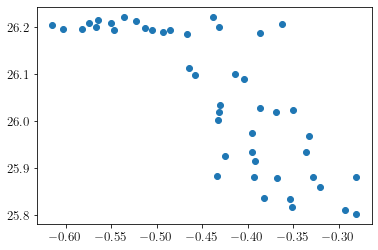

In [12]:
import matplotlib.pyplot as plt

plt.scatter(evolver.population.objectives[:,0],evolver.population.objectives[:,1])
#plt.errorbar(evolver.population.objectives[:,0],evolver.population.objectives[:,1], yerr, marker='s', mfc='red',
#         mec='green', ms=20, mew=4)
plt.show()

In [19]:
evolver.population.objectives

array([[-0.43073059, 26.03558967],
       [-0.43328288, 25.88310389],
       [-0.39493551, 25.93422472],
       [-0.40409427, 26.09050348],
       [-0.43121352, 26.01961176],
       [-0.36263554, 26.20577052],
       [-0.38665863, 26.02807731],
       [-0.52273923, 26.21353314],
       [-0.55051741, 26.20965423],
       [-0.43265004, 26.00209561],
       [-0.56440459, 26.21599779],
       [-0.57445574, 26.20780731],
       [-0.38218603, 25.83618385],
       [-0.3928895 , 25.88075235],
       [-0.32003129, 25.85999174],
       [-0.42519843, 25.92664334],
       [-0.56683858, 26.20065456],
       [-0.38673528, 26.18810571],
       [-0.45834128, 26.09849488],
       [-0.3953556 , 25.9745485 ],
       [-0.50465436, 26.19460857],
       [-0.33593843, 25.93415202],
       [-0.2808171 , 25.80221759],
       [-0.28048217, 25.88091693],
       [-0.51251657, 26.19788366],
       [-0.49306039, 26.18882563],
       [-0.53559427, 26.22137472],
       [-0.60266967, 26.19641228],
       [-0.54735947,

In [14]:
soln_samples = np.asarray(f_xx(evolver.population.individuals))
soln_samples = np.transpose(soln_samples,(0,2,1))
soln_std = np.std(soln_samples,axis=2)

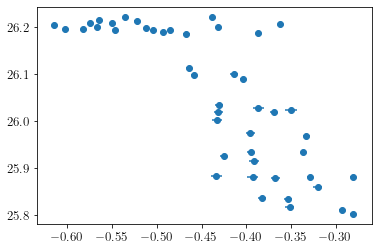

In [15]:
import matplotlib.pyplot as plt

#plt.scatter(evolver.population.objectives[:,0],evolver.population.objectives[:,1])
plt.errorbar(x=evolver.population.objectives[:,0],y=evolver.population.objectives[:,1], xerr=2*soln_std[:,0], yerr=2*soln_std[:,1],fmt ='o')
plt.show()

In [16]:
x=np.random.rand(100)
#x1=evolver.population.individuals[0]
#x=logit(1-0.5*(1-x))
beta_mean=np.array([0.85, -0.5, -0.75, 0])
#beta_mean=np.array([5, -10, 0 , 0])
beta_sd = np.array([0.0, 0.0, 0.0, 0.25])
n_eval = 100
objective_unc(x)

array([-1.05590786e-17,  3.36999480e+01])

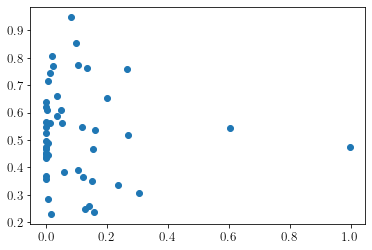

In [20]:
plt.scatter(evolver.population.individuals[0,0:int((n_vars/2)-1)],evolver.population.individuals[0,int(n_vars/2):n_vars-1])
plt.show()

In [68]:
evolver.population.individuals

array([[0.36540237, 0.98159232, 0.53023392, ..., 0.30796491, 0.27957803,
        0.13814907],
       [0.36536907, 0.98149824, 0.52935576, ..., 0.30793585, 0.20053679,
        0.12917797],
       [0.36279423, 0.98282614, 0.53079709, ..., 0.66922823, 0.28174557,
        0.15480656],
       ...,
       [0.36262934, 0.98160563, 0.53233376, ..., 0.66936073, 0.20509897,
        0.61931443],
       [0.36218278, 0.98167369, 0.50372817, ..., 0.66385639, 0.28003698,
        0.68027032],
       [0.36229055, 0.98158216, 0.5313311 , ..., 0.66414429, 0.28193979,
        0.61346462]])